In [78]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import optimizers
from matplotlib.ticker import MaxNLocator
from tensorflow.keras import regularizers, initializers
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [65]:
rng = np.random.default_rng(12345)

In [66]:
'''
[x1, ..., x6]
pos_r: rate of positive tweets
neg_r: rate of negative tw
neu_r: rate of neutral tw
n_tw: volume of tweets
pk: max number of tweets per hour
n_tw_ver: number of tweets from Elon musk or tesla
'''
n_features, n_days = 6, 2000
x = np.zeros((n_features, n_days))
y = np.zeros((n_days))
#Lets generate 900 good days
n=1400
tw_max = 4000
pos_r, neg_r, neu_r, n_tw, pk, n_tw_ver = (rng.integers(low= 15, high= tw_max, size = n),
                                           rng.integers(low= 15, high= tw_max, size = n),
                                           rng.integers(low= 15, high= 50, size = n),
                                           rng.integers(low= 15, high= tw_max, size = n),
                                           rng.integers(low= 1, high= 200, size = n),
                                           rng.integers(low= 0, high= 10, size = n)
                                           )
tot_tw = pos_r+neu_r+neg_r
pos_r, neg_r, neu_r = pos_r/tot_tw, neg_r/tot_tw, neu_r/tot_tw
x[:,0:n] = np.array([pos_r, neg_r, neu_r, n_tw, pk, n_tw_ver])
y[0:n] = 1

In [67]:
#Lets generate 600 bad days
n= n_days - n
tw_max = 4000
pos_r, neg_r, neu_r, n_tw, pk, n_tw_ver = (rng.integers(low= 15, high= 50, size = n),
                                           rng.integers(low= 15, high= tw_max, size = n),
                                           rng.integers(low= 15, high= tw_max, size = n),
                                           rng.integers(low= 15, high= tw_max, size = n),
                                           rng.integers(low= 1, high= 200, size = n),
                                           rng.integers(low= 0, high= 5, size = n)
                                           )
tot_tw = pos_r+neu_r+neg_r
pos_r, neg_r, neu_r = pos_r/tot_tw, neg_r/tot_tw, neu_r/tot_tw
x[:,n_days-n:] = np.array([pos_r, neg_r, neu_r, n_tw, pk, n_tw_ver])
y[n_days-n:] = 0
len(y[y==0])

600

In [68]:
x, y = shuffle(x.T, y, random_state=0) #Now x is (1200,6)

In [69]:
lr=1e-5
##PREPROSESADO DE DATOS
dim = n_days
epochs=200
batch_size=128
(x_train, y_train), (x_test, y_test) = (x[0:1500], y[0:1500]), (x[1500:], y[1500:])

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_val = x_train[0:300]
y_val = y_train[0:300]

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 16)                112       
                                                                 
 dense_61 (Dense)            (None, 16)                272       
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


12/12 [==============================] - 1s 19ms/step - loss: 168.1596 - accuracy: 0.3300 - val_loss: 161.7964 - val_accuracy: 0.3400
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 165.4292 - accuracy: 0.3293 - val_loss: 159.5454 - val_accuracy: 0.3400
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 163.1744 - accuracy: 0.3293 - val_loss: 157.4414 - val_accuracy: 0.3400
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 161.0031 - accuracy: 0.3293 - val_loss: 155.3575 - val_accuracy: 0.3433
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 158.8563 - accuracy: 0.3313 - val_loss: 153.2957 - val_accuracy: 0.3433
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 156.7198 - accuracy: 0.3327 - val_loss: 151.2506 - val_accuracy: 0.3433
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 154.5949 - accuracy: 0.3327 - val_loss: 149.2005 - val_accuracy: 0.3

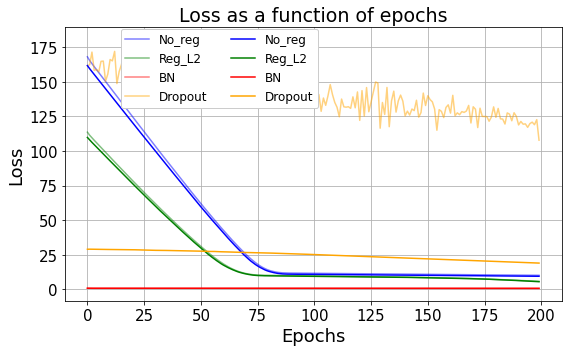

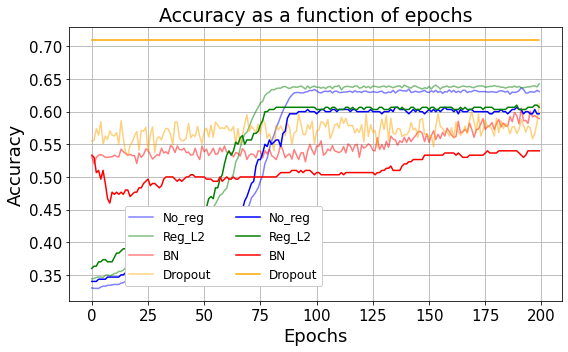

In [132]:
loss=[]
acc=[]
res=[]

##No regularizer (Most likely overfitting)
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=[x.shape[1]]))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr) 
model.compile(optimizer=optimizer, loss='binary_crossentropy',
	metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val,y_val))
results = model.evaluate(x_test, y_test)

loss.append(history.history['loss'])
loss.append(history.history['val_loss'])
acc.append(history.history['accuracy'])
acc.append(history.history['val_accuracy'])
res.append(results)

##With L2 regularizer
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=[x.shape[1]],
	kernel_regularizer=regularizers.l2(1e-3),
    bias_regularizer=regularizers.l2(1e-2)))
model.add(Dense(units=16, activation='relu',
	kernel_regularizer=regularizers.l2(1e-3),
    bias_regularizer=regularizers.l2(1e-2)))
model.add(Dense(units=1, activation='sigmoid',
	kernel_regularizer=regularizers.l2(1e-3),
    bias_regularizer=regularizers.l2(1e-2)))
optimizer = optimizers.RMSprop(lr=lr) 
model.compile(optimizer=optimizer, loss='binary_crossentropy',
	metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
	validation_data=(x_val,y_val))

results = model.evaluate(x_test, y_test)

loss.append(history.history['loss'])
loss.append(history.history['val_loss'])
acc.append(history.history['accuracy'])
acc.append(history.history['val_accuracy'])
res.append(results)


##With BatchNormalization (Almost mandatory)
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=[x.shape[1]]
 ))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu'
 ))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr) 
model.compile(optimizer=optimizer, loss='binary_crossentropy',
	metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
	validation_data=(x_val,y_val))

results = model.evaluate(x_test, y_test)

loss.append(history.history['loss'])
loss.append(history.history['val_loss'])
acc.append(history.history['accuracy'])
acc.append(history.history['val_accuracy'])
res.append(results)



##With DROPOUT
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=[x.shape[1]]))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=lr) 
model.compile(optimizer=optimizer, loss='binary_crossentropy',
	metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
	validation_data=(x_val,y_val))

results = model.evaluate(x_test, y_test)

loss.append(history.history['loss'])
loss.append(history.history['val_loss'])
acc.append(history.history['accuracy'])
acc.append(history.history['val_accuracy'])
res.append(results)

##Plots
fnt = 17
fig_t=plt.figure(figsize=(8,5))
plt.plot(loss[0],label="No_reg", color="blue", alpha=0.5)
plt.plot(loss[2],label="Reg_L2", color="green", alpha=0.5)
plt.plot(loss[4],label="BN", color="red", alpha=0.5)
plt.plot(loss[6],label="Dropout", color="orange", alpha=0.5)
plt.plot(loss[1],label="No_reg", color="blue")
plt.plot(loss[3],label="Reg_L2", color="green")
plt.plot(loss[5],label="BN", color="red")
plt.plot(loss[7],label="Dropout", color="orange")
plt.xlabel(r"Epochs",fontsize=fnt+1)                                         
plt.ylabel(r"Loss",fontsize=fnt+1)
plt.title(r"Loss as a function of epochs", fontsize=fnt+2)
plt.xticks(fontsize=fnt-2) 
plt.yticks(fontsize=fnt-2)   
plt.legend(bbox_to_anchor=(0.1,0.85),ncol=2,fontsize=fnt-5,framealpha=1,loc=6) 
plt.tight_layout()
plt.grid()
fig_t.savefig("EJ3_Loss.pdf")

##PLOTEOS
fnt = 17
fig_t=plt.figure(figsize=(8,5))
plt.plot(acc[0],label="No_reg", color="blue", alpha=0.5)
plt.plot(acc[2],label="Reg_L2", color="green", alpha=0.5)
plt.plot(acc[4],label="BN", color="red", alpha=0.5)
plt.plot(acc[6],label="Dropout", color="orange", alpha=0.5)
plt.plot(acc[1],label="No_reg", color="blue")
plt.plot(acc[3],label="Reg_L2", color="green")
plt.plot(acc[5],label="BN", color="red")
plt.plot(acc[7],label="Dropout", color="orange")
plt.xlabel(r"Epochs",fontsize=fnt+1)                                         
plt.ylabel(r"Accuracy",fontsize=fnt+1)
plt.title(r"Accuracy as a function of epochs", fontsize=fnt+2)
plt.xticks(fontsize=fnt-2) 
plt.yticks(fontsize=fnt-2)   
plt.legend(bbox_to_anchor=(0.1,0.2),ncol=2,fontsize=fnt-5,framealpha=1,loc=6) 
plt.tight_layout()
plt.grid()
fig_t.savefig("EJ3_acc.pdf")
plt.show()

In [76]:
#Parameters of the classifiers
Lamba = 0.1		#Regularization parameter
alpha = 0.000005		#gradient regularizer parameter
batch = 128		#Batch
n_class = 2			#number of classes (2)
epocas = 10		#Number of epochs
delta = 1

class Linear_Classifier():
	def __init__(self, X, Y):
		"Inicializo el clasificador"
		self.x = np.reshape(X, (X.shape[0],np.prod(X.shape[1:])))
		self.x = np.c_[self.x,np.ones(X.shape[0])]
		self.x = self.x.transpose(1,0) 
		self.y = Y
		self.X = X
		self.n = self.x.shape[1] #n elementos
		self.W = np.random.randn(n_class, self.x.shape[0]) * 1e-3

	def loss_gradient():
		pass

	def predict(self, X):
		X = np.reshape(X, (X.shape[0],np.prod(X.shape[1:])))
		X = np.c_[X,np.ones(X.shape[0])] #ej (3073, 50000)
		X = X.transpose(1,0) #ej (50000, 3073)
		aux = self.W.dot(X)
		aux = aux.T
		aux = np.argmax(aux,axis=1)
		return aux

	def fit(self, batch_size):

		loss = np.zeros(epocas)
		acc = np.zeros(epocas)
		idx = np.arange(self.n)		
		
		for i in range(epocas):
			loss_sum=0
			np.random.shuffle(idx)
			for j in range(self.n//batch_size):
				idx_aux = idx[j*batch_size:(j+1)*batch_size]
				x_batch = self.x[:,idx_aux]
				y_batch = self.y[idx_aux]
				
				loss_i, dw_i = self.loss_gradient(x_batch, y_batch)
				loss_sum += loss_i
				self.W = self.W - alpha * dw_i
			
			#Tomo al azar Batch_size puntos de testeo
			np.random.shuffle(idx)
			idx_aux = idx[i*batch_size:(i+1)*batch_size]
			x_batch = self.X[idx_aux]
			y_batch = self.y[idx_aux]
			y_pred_t = self.predict(x_batch)
			acc[i] += np.count_nonzero(y_pred_t == y_batch)/len(y_batch)
			loss[i] = loss_sum
			print('''Epoca: {} -- Presición: {:.2f}% -- Loss: {:.2f}
				'''.format(i,acc[i], loss[i]))
		
		# # Use este plot para sacar el gráfico del informe
		# print("Aca Plotea")
		# fig1 = plt.figure()
		# ax1  = fig1.add_subplot(1,1,1)
		# t1 = ax1.set_title(r'SoftMax MNIST')
		# ax1.set_xlabel(r'Epoca')
		# ax1.set_ylabel(r'Perdidas')
		# ax1.grid()
		# fig1.tight_layout()
		# ax1.plot(loss,color="blue", alpha=1)
		# ax1.legend(["Predidas (Loss)"])
		# plt.show()
		# # print("No ploteo")


class SVM(Linear_Classifier):
	def __init__(self, X, Y):
		super().__init__(X, Y)

	def loss_gradient(self, x_batch, y_batch):
		#Calculo los puntos, luego las perdidas y gradiente
		aux = self.W.dot(x_batch)			#Matriz de salida
		yi = aux[y_batch,range(len(y_batch))] #Valores correctos
		aux2 = aux - yi + delta					#Resto los mismos
		aux6 = np.zeros(aux2.shape)
		aux6[y_batch,range(len(y_batch))] = delta
		aux2 = aux2-aux6
		#import ipdb; ipdb.set_trace(context=15)
		aux3 = aux2.copy()					#armo L
		aux3[aux3>0]=1
		aux3[aux3<0]=0
		aux4 = -aux3.sum(0)					
		aux3[y_batch,range(batch)]=aux4
		dw = x_batch.dot(aux3.T)/len(y_batch) #(features,n_batch)
		dw = dw.T + self.W 					  #calculo del gradiente
		
		#Calculo la perdida
		aux2[aux2<0]=0 						
		aux2 = aux2.sum(0)
		loss = aux2.mean() + 0.5*(self.W**2).sum()
		return loss, dw


class SoftMax(Linear_Classifier):
	# def __init__(self, X, Y):
	# 	super().__init__(X, Y)

	def loss_gradient(self, x_batch, y_batch):
		##Primero normalizo para que no explote
		aux = self.W.dot(x_batch) #(10, batch)
		aux = aux.T
		aux -= aux.max(axis=1)[:, np.newaxis]
		
		#Calculo la loss
		yi = aux[range(len(y_batch)),y_batch]
		aux = np.exp(aux)
		sum_aux = aux.sum(axis=1)
		aux2 = np.log(sum_aux) - yi
		
		#import ipdb; ipdb.set_trace(context=15)
		loss = aux2.mean() + 0.5*(self.W**2).sum()
		#print(loss)
		
		#Calculo el gradiente
		ess = 1/sum_aux					#invierto
		aux3 = ess[:,np.newaxis]*aux 	#Producto punto a punto
		aux3[range(len(y_batch)),y_batch]-=1 #Resto 1 en puntos crrectos
		dw = x_batch.dot(aux3)/len(y_batch) #
		# import ipdb; ipdb.set_trace(context=15)
		dw = dw.T + self.W 				#calculo de gradiente
		
		return loss, dw



In [77]:

##Adquisición de los datos
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# y_train = np.squeeze(y_train)
# y_test = np.squeeze(y_test)
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

##Evaluación e impresión de los resultados

print("Evaluamos con SoftMax en la base de datos \n")
classif = SoftMax(x_train, y_train)
classif.fit(batch)
out = classif.predict(x_test)
print('''Probabilidad de acierto en el test: {}%\n\n\n\n'''
	.format(100*np.count_nonzero(out == y_test)/len(y_test)))



print("Evaluamos con SVM en la base de datos \n")
classif = SVM(x_train, y_train)
classif.fit(batch)
out = classif.predict(x_test)
print('''Probabilidad de acierto en el test: {}%\n\n'''
	.format(100*np.count_nonzero(out == y_test)/len(y_test)))


Evaluamos con SoftMax en la base de datos 

Epoca: 0 -- Presición: 0.33% -- Loss: 38.06
				
Epoca: 1 -- Presición: 0.35% -- Loss: 39.97
				
Epoca: 2 -- Presición: 0.67% -- Loss: 44.44
				
Epoca: 3 -- Presición: 0.28% -- Loss: 40.30
				
Epoca: 4 -- Presición: 0.32% -- Loss: 40.36
				
Epoca: 5 -- Presición: 0.68% -- Loss: 37.59
				
Epoca: 6 -- Presición: 0.27% -- Loss: 34.55
				
Epoca: 7 -- Presición: 0.73% -- Loss: 32.78
				
Epoca: 8 -- Presición: 0.73% -- Loss: 35.49
				
Epoca: 9 -- Presición: 0.23% -- Loss: 43.73
				
Probabilidad de acierto en el test: 29.2%




Evaluamos con SVM en la base de datos 

Epoca: 0 -- Presición: 0.62% -- Loss: 46.46
				
Epoca: 1 -- Presición: 0.70% -- Loss: 52.76
				
Epoca: 2 -- Presición: 0.58% -- Loss: 47.35
				
Epoca: 3 -- Presición: 0.77% -- Loss: 44.69
				
Epoca: 4 -- Presición: 0.70% -- Loss: 40.73
				
Epoca: 5 -- Presición: 0.70% -- Loss: 45.27
				
Epoca: 6 -- Presición: 0.73% -- Loss: 43.85
				
Epoca: 7 -- Presición: 0.30% -- Loss:

In [48]:
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


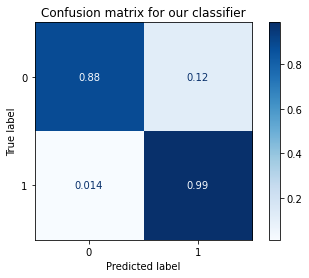

In [49]:
# Initialize SVM classifier
clf = svm.SVC(kernel='linear')

# Fit data
clf = clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
# Generate confusion matrix
matrix = plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

Accuracy: 0.98
Precision: 0.9805555555555555
Recall: 0.9915730337078652


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


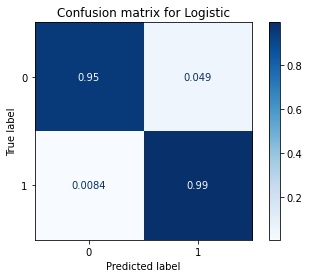

In [79]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
# Generate confusion matrix
matrix = plot_confusion_matrix(model, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for Logistic')
plt.show(matrix)
plt.show()